# 1 Installation

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

In [12]:
from apparel import ApparelDataset, ApparelStackedDataset, ApparelProfiler

# 2 Settings

In [13]:
LABELS = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [14]:
MODEL_PATH = "models/v3.h5"

In [15]:
PREDICTIONS_PATH = "predictions/v3.csv"

In [16]:
BATCH_SIZE = 16  # Samples per batch to load during training.

In [17]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [18]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 4

In [19]:
RANDOM_STATE = 53  # Seed for randomized functions.

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [20]:
VALIDATION_SPLIT_RATIO = 0.2  # Ratio of validation datapoints.
TEST_SPLIT_RATIO = 0.5  # Ratio of test datapoints.

In [21]:
EPOCHS = 10  # Iterations during the training process.

In [22]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [23]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping

In [24]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [25]:
LOADER_WORKERS = 4  # Amount of workers to use to load images.

In [26]:
AUGMENTED_RECORDS = 0.1  # Amount of records to include in data augmentation.

In [27]:
PRETRAINED_TRANSFORMER_NAME = 'google/vit-base-patch16-224'  # Too heavy but more powerful.
PRETRAINED_TRANSFORMER_NAME = 'facebook/deit-tiny-patch16-224'

In [28]:
STOP_AT_BATCH = None  # This is for debugging purposes. Should be set to None.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [29]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <apparel.ApparelDataset object at 0x1643b89d0> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [30]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [31]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [32]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

In [33]:
sample_dataset(train_dataset)

In [34]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

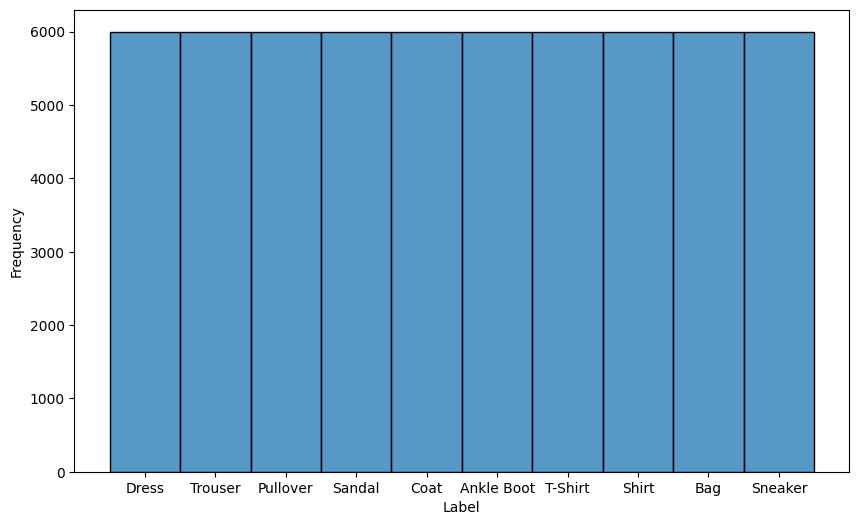

In [35]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [36]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [37]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [38]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [39]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation, sample=AUGMENTED_RECORDS)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <apparel.ApparelDataset object at 0x164405100> 6000 records


In [40]:
augmented_train_dataset = ApparelStackedDataset(train_dataset, augmented_dataset)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == len(train_dataset) + len(augmented_dataset)
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]

Augmented training dataset dataset: <apparel.ApparelStackedDataset object at 0x164c0f1f0> 66000 records


# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

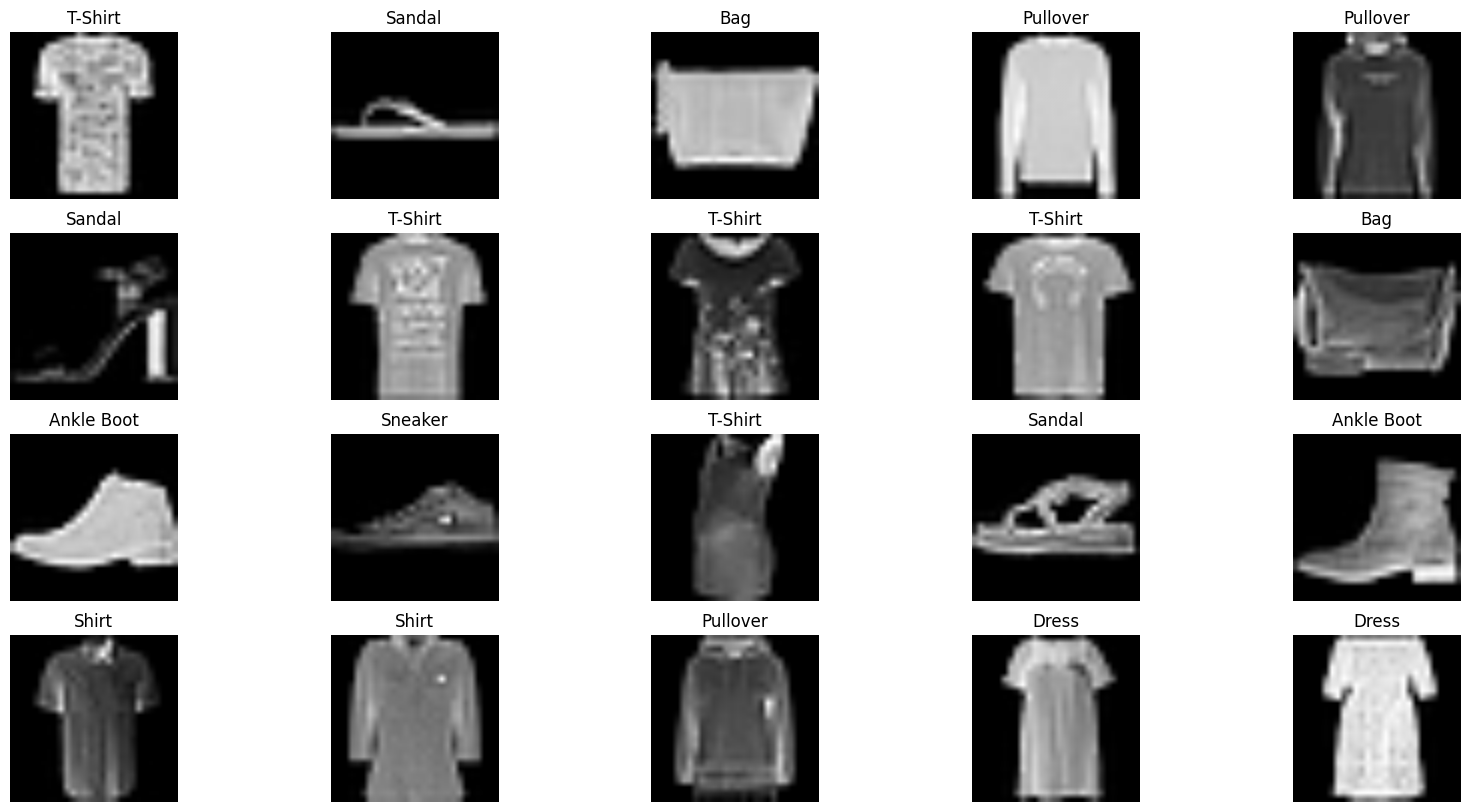

In [41]:
sample_dataset(augmented_train_dataset)

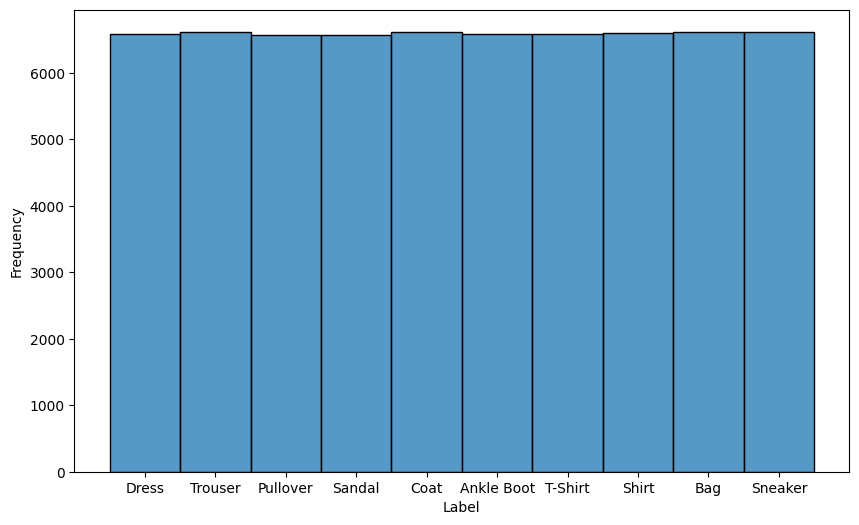

In [42]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [43]:
df = augmented_train_dataset.df
train_indices, val_test_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=TEST_SPLIT_RATIO, 
    stratify=[df.label[i] for i in val_test_indices], 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(test_indices) + len(val_indices)


print("Training indices:", train_indices[:10], "...")
print("Test indices:", test_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

Training indices: [19830, 33745, 46030, 31844, 59742, 52355, 31652, 53646, 28280, 18203] ...
Test indices: [45425, 59041, 20335, 62195, 65221, 56026, 26403, 51798, 46371, 35746] ...
Validation indices: [13636, 51228, 25484, 40429, 20874, 55068, 37388, 9355, 3758, 27047] ...


In [44]:
train_subset = Subset(augmented_train_dataset, train_indices)
test_subset = Subset(augmented_train_dataset, test_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(test_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Test dataset:", test_subset, len(test_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

Training dataset: <torch.utils.data.dataset.Subset object at 0x16530d220> 52800 records
Test dataset: <torch.utils.data.dataset.Subset object at 0x16530d550> 6600 records
Validation dataset: <torch.utils.data.dataset.Subset object at 0x16530d280> 6600 records


In [45]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [46]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()

        self.base_model = base_model
        # Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(1024, 512),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(512, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

    def forward(self, x):
        # profiler = ApparelProfiler("Forward")
        # profiler.measure("BaseModel")
        x = self.base_model.vit(x)
        # profiler.measure("NewLayers")
        x = x.last_hidden_state[:, 0]
        x = self.new_layers(x)
        # profiler.stop()
        return x

In [47]:
base_model = ViTForImageClassification.from_pretrained(
    PRETRAINED_TRANSFORMER_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ApparelsModel(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
        

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [49]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - current_batch
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [50]:
def train_epoch(model: ApparelsModel) -> ApparelsModel:
    model.train()
    start_time = time.time()
    for batch_number, batch in enumerate(train_loader):
        print(datetime.now(), "Train - Batch:", batch_number, "of", len(train_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_number == STOP_AT_BATCH: break
    return model

In [51]:
def evaluate_model(model: ApparelsModel, loader: DataLoader) -> Tuple[float, float, np.array]:
    loss = 0
    y_hat = []
    y_true = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(loader):
            print(datetime.now(), "Val - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            loss += batch_loss.item()
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    loss /= len(loader)
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    return loss, accuracy, conf_matrix

In [52]:
def train(model: ApparelsModel, epochs: int, best_loss: float = float('inf')) -> Tuple[ApparelsModel, List[float]]:
    early_stop_counter = 0
    accuracies: List[float] = []
    for epoch in range(epochs):
        print(datetime.now(), "Epoch:", epoch)
        model = train_epoch(model)
        val_loss, val_accuracy, _ = evaluate_model(model, val_loader)
        accuracies.append(val_accuracy)
        print(datetime.now(), "Epoch:", epoch, "of", epochs, "Loss:", val_loss, "Accuracy:", val_accuracy),
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            continue
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            model.load_state_dict(torch.load(MODEL_PATH))
            break
    print(datetime.now(), "Training complete!")
    return model, accuracies

In [53]:
model, accuracies = train(model=model, epochs=EPOCHS)
print(f"Model Accuracy: {accuracies[-1]}")

2024-06-23 15:37:49.540309 Epoch: 0
2024-06-23 15:38:00.562181 Train - Batch: 0 of 3300 ETA: 2024-06-24 01:44:07.235688
2024-06-23 15:38:01.068565 Train - Batch: 1 of 3300 ETA: 2024-06-24 02:11:47.067547
2024-06-23 15:38:01.527787 Train - Batch: 2 of 3300 ETA: 2024-06-23 21:07:26.029888
2024-06-23 15:38:02.052669 Train - Batch: 3 of 3300 ETA: 2024-06-23 19:27:11.231794
2024-06-23 15:38:02.499615 Train - Batch: 4 of 3300 ETA: 2024-06-23 18:35:59.539143
2024-06-23 15:38:03.001993 Train - Batch: 5 of 3300 ETA: 2024-06-23 18:05:53.109828
2024-06-23 15:38:03.499395 Train - Batch: 6 of 3300 ETA: 2024-06-23 17:45:46.087848
2024-06-23 15:38:03.938946 Train - Batch: 7 of 3300 ETA: 2024-06-23 17:30:56.653493
2024-06-23 15:38:04.388225 Train - Batch: 8 of 3300 ETA: 2024-06-23 17:19:53.592573
2024-06-23 15:38:04.841972 Train - Batch: 9 of 3300 ETA: 2024-06-23 17:11:19.517130
2024-06-23 15:38:05.318240 Train - Batch: 10 of 3300 ETA: 2024-06-23 17:04:35.687371
2024-06-23 15:38:05.785353 Train - Batc

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 16:03:10.247493 Val - Batch: 0 of 413 ETA: 2024-06-23 17:16:59.193503
2024-06-23 16:03:10.695812 Val - Batch: 1 of 413 ETA: 2024-06-23 17:19:53.594868
2024-06-23 16:03:11.122618 Val - Batch: 2 of 413 ETA: 2024-06-23 16:42:54.694936
2024-06-23 16:03:11.533284 Val - Batch: 3 of 413 ETA: 2024-06-23 16:30:32.839425
2024-06-23 16:03:11.946057 Val - Batch: 4 of 413 ETA: 2024-06-23 16:24:22.129331
2024-06-23 16:03:12.356697 Val - Batch: 5 of 413 ETA: 2024-06-23 16:20:39.527057
2024-06-23 16:03:12.766305 Val - Batch: 6 of 413 ETA: 2024-06-23 16:18:11.054548
2024-06-23 16:03:13.182271 Val - Batch: 7 of 413 ETA: 2024-06-23 16:16:25.377844
2024-06-23 16:03:13.596254 Val - Batch: 8 of 413 ETA: 2024-06-23 16:15:06.017898
2024-06-23 16:03:14.008607 Val - Batch: 9 of 413 ETA: 2024-06-23 16:14:04.218748
2024-06-23 16:03:14.415820 Val - Batch: 10 of 413 ETA: 2024-06-23 16:13:14.567182
2024-06-23 16:03:14.824633 Val - Batch: 11 of 413 ETA: 2024-06-23 16:12:34.003213
2024-06-23 16:03:15.238918

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 16:06:21.341070 Epoch: 0 of 10 Loss: 0.44681558176225666 Accuracy: 0.8427272727272728
2024-06-23 16:06:21.430858 Epoch: 1
2024-06-23 16:06:30.668766 Train - Batch: 0 of 3300 ETA: 2024-06-24 00:34:32.373833
2024-06-23 16:06:31.126858 Train - Batch: 1 of 3300 ETA: 2024-06-24 00:59:34.672096
2024-06-23 16:06:31.550814 Train - Batch: 2 of 3300 ETA: 2024-06-23 20:44:37.607218
2024-06-23 16:06:31.971819 Train - Batch: 3 of 3300 ETA: 2024-06-23 19:19:35.302616
2024-06-23 16:06:32.409710 Train - Batch: 4 of 3300 ETA: 2024-06-23 18:37:18.095621
2024-06-23 16:06:32.832411 Train - Batch: 5 of 3300 ETA: 2024-06-23 18:11:45.745628
2024-06-23 16:06:33.257536 Train - Batch: 6 of 3300 ETA: 2024-06-23 17:54:45.513084
2024-06-23 16:06:33.678552 Train - Batch: 7 of 3300 ETA: 2024-06-23 17:42:34.836699
2024-06-23 16:06:34.107974 Train - Batch: 8 of 3300 ETA: 2024-06-23 17:33:30.298132
2024-06-23 16:06:34.530763 Train - Batch: 9 of 3300 ETA: 2024-06-23 17:26:24.335233
2024-06-23 16:06:34.987603 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 16:30:44.008420 Val - Batch: 0 of 413 ETA: 2024-06-23 17:59:19.179688
2024-06-23 16:30:44.528082 Val - Batch: 1 of 413 ETA: 2024-06-23 18:02:40.916407
2024-06-23 16:30:44.994958 Val - Batch: 2 of 413 ETA: 2024-06-23 17:18:12.437509
2024-06-23 16:30:45.457998 Val - Batch: 3 of 413 ETA: 2024-06-23 17:03:22.416169
2024-06-23 16:30:45.920907 Val - Batch: 4 of 413 ETA: 2024-06-23 16:55:57.394644
2024-06-23 16:30:46.395139 Val - Batch: 5 of 413 ETA: 2024-06-23 16:51:31.313146
2024-06-23 16:30:46.853460 Val - Batch: 6 of 413 ETA: 2024-06-23 16:48:32.831793
2024-06-23 16:30:47.334339 Val - Batch: 7 of 413 ETA: 2024-06-23 16:46:26.676497
2024-06-23 16:30:47.838237 Val - Batch: 8 of 413 ETA: 2024-06-23 16:44:53.248016
2024-06-23 16:30:48.318301 Val - Batch: 9 of 413 ETA: 2024-06-23 16:43:39.487441
2024-06-23 16:30:48.798354 Val - Batch: 10 of 413 ETA: 2024-06-23 16:42:40.478765
2024-06-23 16:30:49.283060 Val - Batch: 11 of 413 ETA: 2024-06-23 16:41:52.373601
2024-06-23 16:30:49.759173

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 16:34:18.932282 Epoch: 1 of 10 Loss: 0.39519252136494 Accuracy: 0.8590909090909091
2024-06-23 16:34:18.983806 Epoch: 2
2024-06-23 16:34:31.335706 Train - Batch: 0 of 3300 ETA: 2024-06-24 03:53:48.655693
2024-06-23 16:34:31.868829 Train - Batch: 1 of 3300 ETA: 2024-06-24 04:22:55.396939
2024-06-23 16:34:32.362217 Train - Batch: 2 of 3300 ETA: 2024-06-23 22:42:11.285832
2024-06-23 16:34:32.847343 Train - Batch: 3 of 3300 ETA: 2024-06-23 20:48:27.488772
2024-06-23 16:34:33.331564 Train - Batch: 4 of 3300 ETA: 2024-06-23 19:51:34.845160
2024-06-23 16:34:33.820335 Train - Batch: 5 of 3300 ETA: 2024-06-23 19:17:30.263397
2024-06-23 16:34:34.314395 Train - Batch: 6 of 3300 ETA: 2024-06-23 18:54:50.116045
2024-06-23 16:34:34.800603 Train - Batch: 7 of 3300 ETA: 2024-06-23 18:38:34.880191
2024-06-23 16:34:35.309713 Train - Batch: 8 of 3300 ETA: 2024-06-23 18:26:32.901166
2024-06-23 16:34:35.795999 Train - Batch: 9 of 3300 ETA: 2024-06-23 18:17:02.993457
2024-06-23 16:34:36.280931 Tra

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 16:59:18.334456 Val - Batch: 0 of 413 ETA: 2024-06-23 18:13:07.271079
2024-06-23 16:59:18.776599 Val - Batch: 1 of 413 ETA: 2024-06-23 18:15:59.135271
2024-06-23 16:59:19.198528 Val - Batch: 2 of 413 ETA: 2024-06-23 17:39:00.501495
2024-06-23 16:59:19.612745 Val - Batch: 3 of 413 ETA: 2024-06-23 17:26:39.894872
2024-06-23 16:59:20.023761 Val - Batch: 4 of 413 ETA: 2024-06-23 17:20:29.261425
2024-06-23 16:59:20.435820 Val - Batch: 5 of 413 ETA: 2024-06-23 17:16:46.967340
2024-06-23 16:59:20.850438 Val - Batch: 6 of 413 ETA: 2024-06-23 17:14:18.947456
2024-06-23 16:59:21.272959 Val - Batch: 7 of 413 ETA: 2024-06-23 17:12:33.685236
2024-06-23 16:59:21.706748 Val - Batch: 8 of 413 ETA: 2024-06-23 17:11:15.320325
2024-06-23 16:59:22.163218 Val - Batch: 9 of 413 ETA: 2024-06-23 17:10:15.410547
2024-06-23 16:59:22.573836 Val - Batch: 10 of 413 ETA: 2024-06-23 17:09:25.589039
2024-06-23 16:59:22.995313 Val - Batch: 11 of 413 ETA: 2024-06-23 17:08:45.233738
2024-06-23 16:59:23.408950

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 17:02:30.851460 Epoch: 2 of 10 Loss: 0.37765105178277514 Accuracy: 0.8640909090909091
2024-06-23 17:02:30.899390 Epoch: 3
2024-06-23 17:02:40.365771 Train - Batch: 0 of 3300 ETA: 2024-06-24 01:43:15.614591
2024-06-23 17:02:40.818891 Train - Batch: 1 of 3300 ETA: 2024-06-24 02:08:01.221109
2024-06-23 17:02:41.249718 Train - Batch: 2 of 3300 ETA: 2024-06-23 21:47:06.922505
2024-06-23 17:02:41.678790 Train - Batch: 3 of 3300 ETA: 2024-06-23 20:20:06.895356
2024-06-23 17:02:42.111679 Train - Batch: 4 of 3300 ETA: 2024-06-23 19:36:40.030678
2024-06-23 17:02:42.543258 Train - Batch: 5 of 3300 ETA: 2024-06-23 19:10:35.047039
2024-06-23 17:02:42.968951 Train - Batch: 6 of 3300 ETA: 2024-06-23 18:53:08.487010
2024-06-23 17:02:43.396820 Train - Batch: 7 of 3300 ETA: 2024-06-23 18:40:41.970543
2024-06-23 17:02:43.824317 Train - Batch: 8 of 3300 ETA: 2024-06-23 18:31:21.928493
2024-06-23 17:02:44.252433 Train - Batch: 9 of 3300 ETA: 2024-06-23 18:24:06.568311
2024-06-23 17:02:44.678861 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 17:26:49.716060 Val - Batch: 0 of 413 ETA: 2024-06-23 18:32:02.682559
2024-06-23 17:26:50.155237 Val - Batch: 1 of 413 ETA: 2024-06-23 18:34:54.558048
2024-06-23 17:26:50.571051 Val - Batch: 2 of 413 ETA: 2024-06-23 18:02:13.265476
2024-06-23 17:26:50.981001 Val - Batch: 3 of 413 ETA: 2024-06-23 17:51:18.693988
2024-06-23 17:26:51.389624 Val - Batch: 4 of 413 ETA: 2024-06-23 17:45:51.271202
2024-06-23 17:26:51.802248 Val - Batch: 5 of 413 ETA: 2024-06-23 17:42:35.148045
2024-06-23 17:26:52.228996 Val - Batch: 6 of 413 ETA: 2024-06-23 17:40:25.371469
2024-06-23 17:26:52.639086 Val - Batch: 7 of 413 ETA: 2024-06-23 17:38:51.691090
2024-06-23 17:26:53.064956 Val - Batch: 8 of 413 ETA: 2024-06-23 17:37:42.245446
2024-06-23 17:26:53.484459 Val - Batch: 9 of 413 ETA: 2024-06-23 17:36:47.940006
2024-06-23 17:26:53.905333 Val - Batch: 10 of 413 ETA: 2024-06-23 17:36:04.552262
2024-06-23 17:26:54.320572 Val - Batch: 11 of 413 ETA: 2024-06-23 17:35:28.841593
2024-06-23 17:26:54.754410

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 17:30:02.067100 Epoch: 3 of 10 Loss: 0.3693070970971778 Accuracy: 0.865909090909091
2024-06-23 17:30:02.117244 Epoch: 4
2024-06-23 17:30:11.642834 Train - Batch: 0 of 3300 ETA: 2024-06-24 02:14:02.297459
2024-06-23 17:30:12.106576 Train - Batch: 1 of 3300 ETA: 2024-06-24 02:39:22.858104
2024-06-23 17:30:12.523278 Train - Batch: 2 of 3300 ETA: 2024-06-23 22:16:10.044684
2024-06-23 17:30:12.949261 Train - Batch: 3 of 3300 ETA: 2024-06-23 20:48:35.984916
2024-06-23 17:30:13.379605 Train - Batch: 4 of 3300 ETA: 2024-06-23 20:04:52.551409
2024-06-23 17:30:13.806881 Train - Batch: 5 of 3300 ETA: 2024-06-23 19:38:36.467547
2024-06-23 17:30:14.242121 Train - Batch: 6 of 3300 ETA: 2024-06-23 19:21:10.124853
2024-06-23 17:30:14.669011 Train - Batch: 7 of 3300 ETA: 2024-06-23 19:08:38.800160
2024-06-23 17:30:15.091733 Train - Batch: 8 of 3300 ETA: 2024-06-23 18:59:13.587818
2024-06-23 17:30:15.518851 Train - Batch: 9 of 3300 ETA: 2024-06-23 18:51:55.589984
2024-06-23 17:30:15.944586 Tr

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 17:54:26.288881 Val - Batch: 0 of 413 ETA: 2024-06-23 19:00:44.017221
2024-06-23 17:54:26.731026 Val - Batch: 1 of 413 ETA: 2024-06-23 19:03:36.968610
2024-06-23 17:54:27.143048 Val - Batch: 2 of 413 ETA: 2024-06-23 18:30:21.895696
2024-06-23 17:54:27.561822 Val - Batch: 3 of 413 ETA: 2024-06-23 18:19:17.801051
2024-06-23 17:54:27.974100 Val - Batch: 4 of 413 ETA: 2024-06-23 18:13:45.086319
2024-06-23 17:54:28.388869 Val - Batch: 5 of 413 ETA: 2024-06-23 18:10:25.657684
2024-06-23 17:54:28.804999 Val - Batch: 6 of 413 ETA: 2024-06-23 18:08:12.801362
2024-06-23 17:54:29.222704 Val - Batch: 7 of 413 ETA: 2024-06-23 18:06:37.996846
2024-06-23 17:54:29.636159 Val - Batch: 8 of 413 ETA: 2024-06-23 18:05:26.674074
2024-06-23 17:54:30.049404 Val - Batch: 9 of 413 ETA: 2024-06-23 18:04:31.191101
2024-06-23 17:54:30.467305 Val - Batch: 10 of 413 ETA: 2024-06-23 18:03:46.997070
2024-06-23 17:54:30.886099 Val - Batch: 11 of 413 ETA: 2024-06-23 18:03:10.871804
2024-06-23 17:54:31.305025

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 17:57:39.231108 Epoch: 4 of 10 Loss: 0.364138418506407 Accuracy: 0.863030303030303
2024-06-23 17:57:39.280046 Epoch: 5
2024-06-23 17:57:48.789125 Train - Batch: 0 of 3300 ETA: 2024-06-24 02:40:44.852121
2024-06-23 17:57:49.249212 Train - Batch: 1 of 3300 ETA: 2024-06-24 03:05:53.440335
2024-06-23 17:57:49.682070 Train - Batch: 2 of 3300 ETA: 2024-06-23 22:43:40.574930
2024-06-23 17:57:50.116053 Train - Batch: 3 of 3300 ETA: 2024-06-23 21:16:17.525117
2024-06-23 17:57:50.543072 Train - Batch: 4 of 3300 ETA: 2024-06-23 20:32:30.255528
2024-06-23 17:57:51.010767 Train - Batch: 5 of 3300 ETA: 2024-06-23 20:06:40.739381
2024-06-23 17:57:51.457539 Train - Batch: 6 of 3300 ETA: 2024-06-23 19:49:16.220498
2024-06-23 17:57:51.878678 Train - Batch: 7 of 3300 ETA: 2024-06-23 19:36:38.052306
2024-06-23 17:57:52.308761 Train - Batch: 8 of 3300 ETA: 2024-06-23 19:27:13.114692
2024-06-23 17:57:52.749798 Train - Batch: 9 of 3300 ETA: 2024-06-23 19:19:57.735725
2024-06-23 17:57:53.180868 Tra

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 18:22:07.752428 Val - Batch: 0 of 413 ETA: 2024-06-23 19:36:53.302600
2024-06-23 18:22:08.197634 Val - Batch: 1 of 413 ETA: 2024-06-23 19:39:46.286544
2024-06-23 18:22:08.621587 Val - Batch: 2 of 413 ETA: 2024-06-23 19:02:19.135186
2024-06-23 18:22:09.043535 Val - Batch: 3 of 413 ETA: 2024-06-23 18:49:49.809092
2024-06-23 18:22:09.484485 Val - Batch: 4 of 413 ETA: 2024-06-23 18:43:37.107801
2024-06-23 18:22:09.897059 Val - Batch: 5 of 413 ETA: 2024-06-23 18:39:51.143100
2024-06-23 18:22:10.311687 Val - Batch: 6 of 413 ETA: 2024-06-23 18:37:20.641480
2024-06-23 18:22:10.723535 Val - Batch: 7 of 413 ETA: 2024-06-23 18:35:32.976178
2024-06-23 18:22:11.136113 Val - Batch: 8 of 413 ETA: 2024-06-23 18:34:12.264902
2024-06-23 18:22:11.549691 Val - Batch: 9 of 413 ETA: 2024-06-23 18:33:09.535396
2024-06-23 18:22:11.964885 Val - Batch: 10 of 413 ETA: 2024-06-23 18:32:19.418569
2024-06-23 18:22:12.379536 Val - Batch: 11 of 413 ETA: 2024-06-23 18:31:38.393466
2024-06-23 18:22:12.797474

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 18:25:21.382253 Epoch: 5 of 10 Loss: 0.35977775323910516 Accuracy: 0.8678787878787879
2024-06-23 18:25:21.430959 Epoch: 6
2024-06-23 18:25:31.941062 Train - Batch: 0 of 3300 ETA: 2024-06-24 04:03:31.423405
2024-06-23 18:25:32.416354 Train - Batch: 1 of 3300 ETA: 2024-06-24 04:29:29.199362
2024-06-23 18:25:32.848907 Train - Batch: 2 of 3300 ETA: 2024-06-23 23:39:19.028319
2024-06-23 18:25:33.272357 Train - Batch: 3 of 3300 ETA: 2024-06-23 22:02:25.623573
2024-06-23 18:25:33.696178 Train - Batch: 4 of 3300 ETA: 2024-06-23 21:13:59.229003
2024-06-23 18:25:34.154022 Train - Batch: 5 of 3300 ETA: 2024-06-23 20:45:17.846695
2024-06-23 18:25:34.599109 Train - Batch: 6 of 3300 ETA: 2024-06-23 20:26:03.241450
2024-06-23 18:25:35.032039 Train - Batch: 7 of 3300 ETA: 2024-06-23 20:12:12.793400
2024-06-23 18:25:35.482235 Train - Batch: 8 of 3300 ETA: 2024-06-23 20:01:57.078621
2024-06-23 18:25:35.913889 Train - Batch: 9 of 3300 ETA: 2024-06-23 19:53:51.391382
2024-06-23 18:25:36.346336 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 18:49:58.056922 Val - Batch: 0 of 413 ETA: 2024-06-23 20:04:13.753837
2024-06-23 18:49:58.502979 Val - Batch: 1 of 413 ETA: 2024-06-23 20:07:07.149874
2024-06-23 18:49:58.918363 Val - Batch: 2 of 413 ETA: 2024-06-23 19:29:52.986198
2024-06-23 18:49:59.331102 Val - Batch: 3 of 413 ETA: 2024-06-23 19:17:27.900547
2024-06-23 18:49:59.746646 Val - Batch: 4 of 413 ETA: 2024-06-23 19:11:15.647509
2024-06-23 18:50:00.173240 Val - Batch: 5 of 413 ETA: 2024-06-23 19:07:33.208278
2024-06-23 18:50:00.594489 Val - Batch: 6 of 413 ETA: 2024-06-23 19:05:04.547815
2024-06-23 18:50:01.014255 Val - Batch: 7 of 413 ETA: 2024-06-23 19:03:18.274035
2024-06-23 18:50:01.426063 Val - Batch: 8 of 413 ETA: 2024-06-23 19:01:58.157811
2024-06-23 18:50:01.839259 Val - Batch: 9 of 413 ETA: 2024-06-23 19:00:55.908944
2024-06-23 18:50:02.261601 Val - Batch: 10 of 413 ETA: 2024-06-23 19:00:06.487666
2024-06-23 18:50:02.679717 Val - Batch: 11 of 413 ETA: 2024-06-23 18:59:25.893358
2024-06-23 18:50:03.098172

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 18:53:11.678629 Epoch: 6 of 10 Loss: 0.35616494620503003 Accuracy: 0.8696969696969697
2024-06-23 18:53:11.725317 Epoch: 7
2024-06-23 18:53:22.334554 Train - Batch: 0 of 3300 ETA: 2024-06-24 04:36:48.925937
2024-06-23 18:53:22.791398 Train - Batch: 1 of 3300 ETA: 2024-06-24 05:01:45.757826
2024-06-23 18:53:23.220533 Train - Batch: 2 of 3300 ETA: 2024-06-24 00:09:16.813508
2024-06-23 18:53:23.652026 Train - Batch: 3 of 3300 ETA: 2024-06-23 22:31:49.759943
2024-06-23 18:53:24.096017 Train - Batch: 4 of 3300 ETA: 2024-06-23 21:43:16.544325
2024-06-23 18:53:24.519593 Train - Batch: 5 of 3300 ETA: 2024-06-23 21:13:55.140850
2024-06-23 18:53:24.940630 Train - Batch: 6 of 3300 ETA: 2024-06-23 20:54:19.475462
2024-06-23 18:53:25.375630 Train - Batch: 7 of 3300 ETA: 2024-06-23 20:40:26.296571
2024-06-23 18:53:25.800593 Train - Batch: 8 of 3300 ETA: 2024-06-23 20:29:57.273442
2024-06-23 18:53:26.234568 Train - Batch: 9 of 3300 ETA: 2024-06-23 20:21:51.336486
2024-06-23 18:53:26.669173 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 19:17:54.154937 Val - Batch: 0 of 413 ETA: 2024-06-23 20:32:27.800754
2024-06-23 19:17:54.608087 Val - Batch: 1 of 413 ETA: 2024-06-23 20:35:24.096407
2024-06-23 19:17:55.034972 Val - Batch: 2 of 413 ETA: 2024-06-23 19:58:01.861649
2024-06-23 19:17:55.456881 Val - Batch: 3 of 413 ETA: 2024-06-23 19:45:33.764766
2024-06-23 19:17:55.878557 Val - Batch: 4 of 413 ETA: 2024-06-23 19:39:19.692446
2024-06-23 19:17:56.314259 Val - Batch: 5 of 413 ETA: 2024-06-23 19:35:36.407457
2024-06-23 19:17:56.734779 Val - Batch: 6 of 413 ETA: 2024-06-23 19:33:06.505902
2024-06-23 19:17:57.153598 Val - Batch: 7 of 413 ETA: 2024-06-23 19:31:19.332882
2024-06-23 19:17:57.599409 Val - Batch: 8 of 413 ETA: 2024-06-23 19:30:00.346684
2024-06-23 19:17:58.042607 Val - Batch: 9 of 413 ETA: 2024-06-23 19:28:58.793062
2024-06-23 19:17:58.466334 Val - Batch: 10 of 413 ETA: 2024-06-23 19:28:08.745898
2024-06-23 19:17:58.886402 Val - Batch: 11 of 413 ETA: 2024-06-23 19:27:27.660936
2024-06-23 19:17:59.298714

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 19:21:08.886452 Epoch: 7 of 10 Loss: 0.35118583891062705 Accuracy: 0.8721212121212121
2024-06-23 19:21:08.935005 Epoch: 8
2024-06-23 19:21:19.411513 Train - Batch: 0 of 3300 ETA: 2024-06-24 04:57:27.993868
2024-06-23 19:21:19.885831 Train - Batch: 1 of 3300 ETA: 2024-06-24 05:23:22.636638
2024-06-23 19:21:20.329645 Train - Batch: 2 of 3300 ETA: 2024-06-24 00:34:28.077639
2024-06-23 19:21:20.762544 Train - Batch: 3 of 3300 ETA: 2024-06-23 22:57:57.886072
2024-06-23 19:21:21.187040 Train - Batch: 4 of 3300 ETA: 2024-06-23 22:09:35.858549
2024-06-23 19:21:21.619678 Train - Batch: 5 of 3300 ETA: 2024-06-23 21:40:40.014649
2024-06-23 19:21:22.056244 Train - Batch: 6 of 3300 ETA: 2024-06-23 21:21:24.954408
2024-06-23 19:21:22.485980 Train - Batch: 7 of 3300 ETA: 2024-06-23 21:07:36.677931
2024-06-23 19:21:22.917073 Train - Batch: 8 of 3300 ETA: 2024-06-23 20:57:16.035680
2024-06-23 19:21:23.348460 Train - Batch: 9 of 3300 ETA: 2024-06-23 20:49:13.421719
2024-06-23 19:21:23.779044 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 19:45:50.506724 Val - Batch: 0 of 413 ETA: 2024-06-23 20:59:04.263892
2024-06-23 19:45:50.950407 Val - Batch: 1 of 413 ETA: 2024-06-23 21:01:56.848572
2024-06-23 19:45:51.370789 Val - Batch: 2 of 413 ETA: 2024-06-23 20:25:15.167247
2024-06-23 19:45:51.789883 Val - Batch: 3 of 413 ETA: 2024-06-23 20:13:01.096134
2024-06-23 19:45:52.215663 Val - Batch: 4 of 413 ETA: 2024-06-23 20:06:54.750928
2024-06-23 19:45:52.649370 Val - Batch: 5 of 413 ETA: 2024-06-23 20:03:15.598570
2024-06-23 19:45:53.132000 Val - Batch: 6 of 413 ETA: 2024-06-23 20:00:52.864531
2024-06-23 19:45:53.550923 Val - Batch: 7 of 413 ETA: 2024-06-23 19:59:07.152942
2024-06-23 19:45:53.970676 Val - Batch: 8 of 413 ETA: 2024-06-23 19:57:47.912082
2024-06-23 19:45:54.395781 Val - Batch: 9 of 413 ETA: 2024-06-23 19:56:46.525912
2024-06-23 19:45:54.812883 Val - Batch: 10 of 413 ETA: 2024-06-23 19:55:57.086452
2024-06-23 19:45:55.232535 Val - Batch: 11 of 413 ETA: 2024-06-23 19:55:16.731714
2024-06-23 19:45:55.647836

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 19:49:05.788747 Epoch: 8 of 10 Loss: 0.34580588795821976 Accuracy: 0.8721212121212121
2024-06-23 19:49:05.837032 Epoch: 9
2024-06-23 19:49:16.344189 Train - Batch: 0 of 3300 ETA: 2024-06-24 05:27:06.035832
2024-06-23 19:49:16.810868 Train - Batch: 1 of 3300 ETA: 2024-06-24 05:52:35.369465
2024-06-23 19:49:17.241167 Train - Batch: 2 of 3300 ETA: 2024-06-24 01:02:40.598878
2024-06-23 19:49:17.689016 Train - Batch: 3 of 3300 ETA: 2024-06-23 23:26:21.644647
2024-06-23 19:49:18.117385 Train - Batch: 4 of 3300 ETA: 2024-06-23 22:37:56.098506
2024-06-23 19:49:18.557992 Train - Batch: 5 of 3300 ETA: 2024-06-23 22:09:00.847761
2024-06-23 19:49:18.989560 Train - Batch: 6 of 3300 ETA: 2024-06-23 21:49:39.041867
2024-06-23 19:49:19.418824 Train - Batch: 7 of 3300 ETA: 2024-06-23 21:35:48.093518
2024-06-23 19:49:19.850443 Train - Batch: 8 of 3300 ETA: 2024-06-23 21:25:25.854719
2024-06-23 19:49:20.283830 Train - Batch: 9 of 3300 ETA: 2024-06-23 21:17:22.538906
2024-06-23 19:49:20.714831 

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 20:13:49.611528 Val - Batch: 0 of 413 ETA: 2024-06-23 21:28:45.414782
2024-06-23 20:13:50.066216 Val - Batch: 1 of 413 ETA: 2024-06-23 21:31:42.281360
2024-06-23 20:13:50.494889 Val - Batch: 2 of 413 ETA: 2024-06-23 20:54:09.024810
2024-06-23 20:13:50.918637 Val - Batch: 3 of 413 ETA: 2024-06-23 20:41:37.261283
2024-06-23 20:13:51.372711 Val - Batch: 4 of 413 ETA: 2024-06-23 20:35:24.510372
2024-06-23 20:13:51.796319 Val - Batch: 5 of 413 ETA: 2024-06-23 20:31:38.343504
2024-06-23 20:13:52.217616 Val - Batch: 6 of 413 ETA: 2024-06-23 20:29:07.406504
2024-06-23 20:13:52.636836 Val - Batch: 7 of 413 ETA: 2024-06-23 20:27:19.471769
2024-06-23 20:13:53.062453 Val - Batch: 8 of 413 ETA: 2024-06-23 20:25:58.851025
2024-06-23 20:13:53.482057 Val - Batch: 9 of 413 ETA: 2024-06-23 20:24:55.870107
2024-06-23 20:13:53.895544 Val - Batch: 10 of 413 ETA: 2024-06-23 20:24:05.232738
2024-06-23 20:13:54.320070 Val - Batch: 11 of 413 ETA: 2024-06-23 20:23:24.216557
2024-06-23 20:13:54.752514

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 20:17:04.509429 Epoch: 9 of 10 Loss: 0.34568169328765197 Accuracy: 0.8740909090909091
2024-06-23 20:17:04.558222 Training complete!
Model Accuracy: 0.8740909090909091


# 11 Model Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [54]:
test_loss, test_accuracy, conf_matrix = evaluate_model(model, test_loader)

2024-06-23 20:17:15.214996 Val - Batch: 0 of 413 ETA: 2024-06-23 21:30:32.093994
2024-06-23 20:17:15.673550 Val - Batch: 1 of 413 ETA: 2024-06-23 21:33:30.798412
2024-06-23 20:17:16.120929 Val - Batch: 2 of 413 ETA: 2024-06-23 20:56:50.067440
2024-06-23 20:17:16.547950 Val - Batch: 3 of 413 ETA: 2024-06-23 20:44:33.687787
2024-06-23 20:17:16.967997 Val - Batch: 4 of 413 ETA: 2024-06-23 20:38:24.777946
2024-06-23 20:17:17.382983 Val - Batch: 5 of 413 ETA: 2024-06-23 20:34:43.014049
2024-06-23 20:17:17.844231 Val - Batch: 6 of 413 ETA: 2024-06-23 20:32:18.355772
2024-06-23 20:17:18.264047 Val - Batch: 7 of 413 ETA: 2024-06-23 20:30:32.583808
2024-06-23 20:17:18.688372 Val - Batch: 8 of 413 ETA: 2024-06-23 20:29:13.487831
2024-06-23 20:17:19.105875 Val - Batch: 9 of 413 ETA: 2024-06-23 20:28:11.655539
2024-06-23 20:17:19.521976 Val - Batch: 10 of 413 ETA: 2024-06-23 20:27:22.131844
2024-06-23 20:17:19.933216 Val - Batch: 11 of 413 ETA: 2024-06-23 20:26:41.429954
2024-06-23 20:17:20.358404

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

In [55]:
print("Test Loss:", test_loss)
print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Test Loss: 0.361047988004315
Accuracy: 0.8716666666666667
Confusion Matrix:
 [[552   0  20  26   8   0  46   0   7   0]
 [  0 639   4  13   1   0   5   0   0   0]
 [ 14   1 549  11  47   0  33   0   3   0]
 [ 23   5   9 574  25   1  18   0   4   0]
 [  2   1  66  32 529   0  29   0   3   0]
 [  4   0   0   0   3 599   0  43   3   6]
 [ 73   0  69  26  62   0 421   0   8   0]
 [  0   0   0   0   1   5   0 632   2  22]
 [  3   0   9   1   7   1   1   0 638   2]
 [  0   0   0   0   0   7   0  31   1 620]]


# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix. This step help update the settings of the model to improve the results. Additionally, there are multiple versions of this model, so at the end of the day, we only keep the best one.

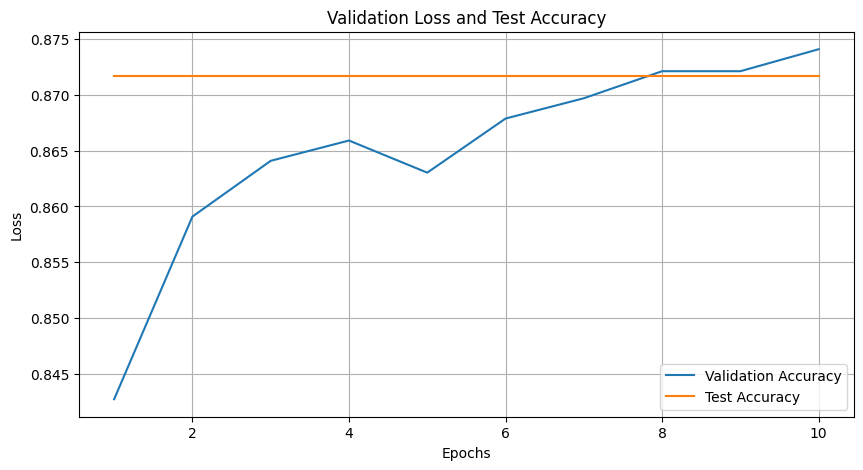

In [56]:
assert len(accuracies) > 0
assert test_accuracy > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.plot(range(1, len(accuracies) + 1), [test_accuracy for _ in range(len(accuracies))], label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

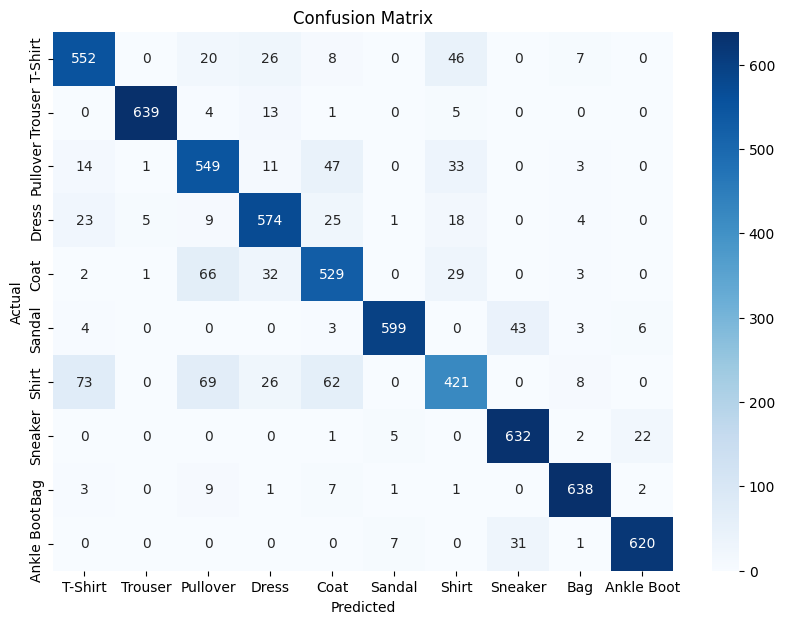

In [57]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Prediction

Generating the CSV to submit to DataHack.

In [58]:
submission_dataset = ApparelDataset.load(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKERS, pin_memory=False)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

Submission dataset: <apparel.ApparelDataset object at 0x16532e3a0> 10000 records.


In [59]:
def predict(model: ApparelsModel, loader: DataLoader) -> np.array:
    y_hat = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, inputs in enumerate(loader):
            print(datetime.now(), "Prediction - Batch:", batch_number, "of", len(loader), "ETA:", get_eta(start_time, batch_number, len(loader)))
            inputs = inputs.to(PROCESSOR)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    return y_hat

In [60]:
predictions = predict(model, submission_loader)

if isinstance(STOP_AT_BATCH, int) and STOP_AT_BATCH >= 0:
    submission_dataset.df = submission_dataset.df.iloc[:len(predictions)].copy()
assert len(predictions) == len(submission_dataset)

submission_dataset.df['label'] = predict(model, submission_loader)
submission_dataset.df.to_csv(PREDICTIONS_PATH, index=False)

2024-06-23 20:20:33.814672 Prediction - Batch: 0 of 625 ETA: 2024-06-23 21:00:03.594104
2024-06-23 20:20:34.294400 Prediction - Batch: 1 of 625 ETA: 2024-06-23 21:04:59.596236
2024-06-23 20:20:34.711932 Prediction - Batch: 2 of 625 ETA: 2024-06-23 20:44:55.288040
2024-06-23 20:20:35.127468 Prediction - Batch: 3 of 625 ETA: 2024-06-23 20:38:13.436431
2024-06-23 20:20:35.565996 Prediction - Batch: 4 of 625 ETA: 2024-06-23 20:34:56.102923
2024-06-23 20:20:35.986909 Prediction - Batch: 5 of 625 ETA: 2024-06-23 20:32:55.501351
2024-06-23 20:20:36.408203 Prediction - Batch: 6 of 625 ETA: 2024-06-23 20:31:35.139567
2024-06-23 20:20:36.823787 Prediction - Batch: 7 of 625 ETA: 2024-06-23 20:30:37.228822
2024-06-23 20:20:37.236263 Prediction - Batch: 8 of 625 ETA: 2024-06-23 20:29:53.552857
2024-06-23 20:20:37.652596 Prediction - Batch: 9 of 625 ETA: 2024-06-23 20:29:19.850186
2024-06-23 20:20:38.079028 Prediction - Batch: 10 of 625 ETA: 2024-06-23 20:28:53.519605
2024-06-23 20:20:38.490514 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

2024-06-23 20:25:22.029325 Prediction - Batch: 0 of 625 ETA: 2024-06-23 21:07:54.070686
2024-06-23 20:25:22.485891 Prediction - Batch: 1 of 625 ETA: 2024-06-23 21:12:35.294886
2024-06-23 20:25:22.912306 Prediction - Batch: 2 of 625 ETA: 2024-06-23 20:51:09.875796
2024-06-23 20:25:23.328543 Prediction - Batch: 3 of 625 ETA: 2024-06-23 20:43:59.281783
2024-06-23 20:25:23.744196 Prediction - Batch: 4 of 625 ETA: 2024-06-23 20:40:23.893506
2024-06-23 20:25:24.163502 Prediction - Batch: 5 of 625 ETA: 2024-06-23 20:38:15.117143
2024-06-23 20:25:24.576904 Prediction - Batch: 6 of 625 ETA: 2024-06-23 20:36:48.651561
2024-06-23 20:25:24.991796 Prediction - Batch: 7 of 625 ETA: 2024-06-23 20:35:47.023285
2024-06-23 20:25:25.404454 Prediction - Batch: 8 of 625 ETA: 2024-06-23 20:35:00.627399
2024-06-23 20:25:25.832339 Prediction - Batch: 9 of 625 ETA: 2024-06-23 20:34:25.599344
2024-06-23 20:25:26.245036 Prediction - Batch: 10 of 625 ETA: 2024-06-23 20:33:56.627534
2024-06-23 20:25:26.676536 Pred

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, cur

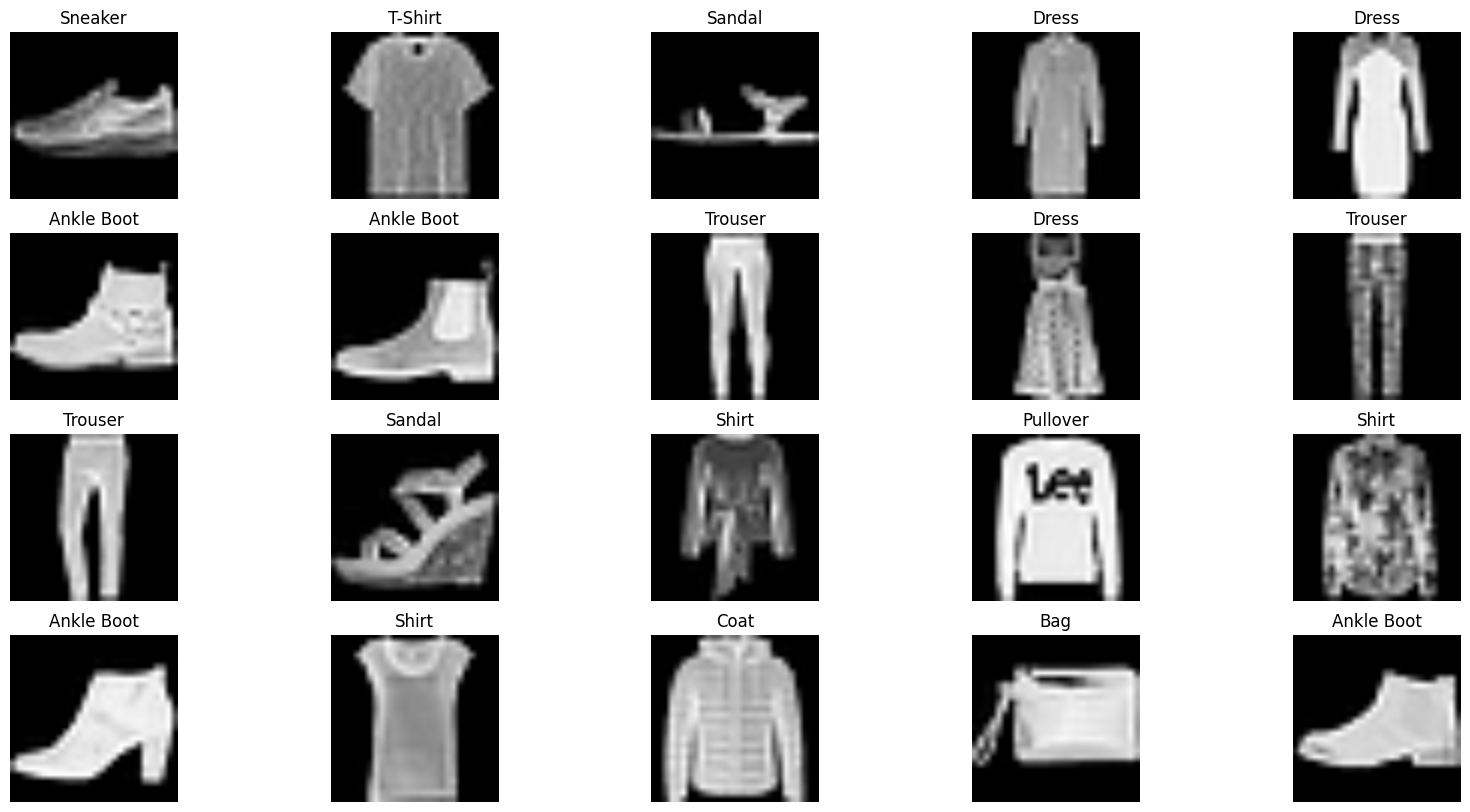

In [61]:
sample_dataset(submission_dataset)